# Fisher Unlearning Evaluation

**Purpose:** Evaluate Fisher-based unlearning against retrain floor target.

**Method:** Fisher-diagonal scrubbing + retain-only fine-tuning

**Target:** AUC within [0.834, 0.894] (retrain floor ± 0.03)

**Evaluation:** Post-hoc evaluation with fresh attacker:
- F vs Unseen (matched negatives)
- F vs Retain (matched)
- Report AUC with 95% CI
- Report TPR @ 1% and 0.1% FPR
- Compute gap-to-floor

In [1]:
import sys
sys.path.append('src')

import torch
import scanpy as sc
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Splits

In [2]:
# Load data
adata = sc.read_h5ad('data/adata_processed.h5ad')
with open('outputs/p1/split_structured.json', 'r') as f:
    splits = json.load(f)

forget_idx = np.array(splits['forget_indices'])
retain_idx = np.array(splits['retain_indices'])
unseen_idx = np.array(splits['unseen_indices'])

print("Split sizes:")
print(f"  Forget:  {len(forget_idx):5d} cells (rare cluster)")
print(f"  Retain:  {len(retain_idx):5d} cells (training set minus forget)")
print(f"  Unseen:  {len(unseen_idx):5d} cells (matched negatives from same cluster)")
print(f"  Total:   {adata.n_obs:5d} cells")

Split sizes:
  Forget:     30 cells (rare cluster)
  Retain:  28094 cells (training set minus forget)
  Unseen:   4964 cells (matched negatives from same cluster)
  Total:   33088 cells


## 2. Load Fisher-Unlearned Model

In [3]:
# Load Fisher-unlearned VAE
fisher_ckpt = torch.load('outputs/p2/fisher_unlearn_structured/unlearned_model.pt', map_location=device)

# Load baseline config to reconstruct architecture
baseline_ckpt = torch.load('outputs/p1/baseline_v2/best_model.pt', map_location=device)
vae_config = baseline_ckpt['config']

input_dim = adata.n_vars  # 2000 genes

vae = VAE(
    input_dim=input_dim,
    hidden_dims=vae_config['hidden_dims'],
    latent_dim=vae_config['latent_dim'],
    likelihood=vae_config['likelihood'],
    dropout=vae_config.get('dropout', 0.1),
    use_layer_norm=vae_config.get('use_layer_norm', True)
).to(device)

vae.load_state_dict(fisher_ckpt['model_state_dict'])
vae.eval()

print("Fisher-unlearned VAE loaded:")
print(f"  Architecture: {input_dim} -> {vae_config['hidden_dims']} -> z={vae_config['latent_dim']}")
print(f"  Likelihood: {vae_config['likelihood']}")

# Load metadata
with open('outputs/p2/fisher_unlearn_structured/metadata.json', 'r') as f:
    metadata = json.load(f)

print("\nFisher unlearning parameters:")
print(f"  Scrub LR: {metadata['scrub_lr']}")
print(f"  Scrub steps: {metadata['scrub_steps']}")
print(f"  Fisher damping: {metadata['fisher_damping']}")
print(f"  Finetune epochs: {metadata['finetune_epochs']}")
print(f"  Total time: {metadata['total_time_seconds']:.1f}s")

Fisher-unlearned VAE loaded:
  Architecture: 2000 -> [1024, 512, 128] -> z=32
  Likelihood: nb

Fisher unlearning parameters:
  Scrub LR: 0.0001
  Scrub steps: 100
  Fisher damping: 0.1
  Finetune epochs: 10
  Total time: 110.4s


## 3. Extract VAE Features for Attacker

In [4]:
def get_features(indices, name):
    """Extract attacker features for a set of indices."""
    X = torch.FloatTensor(
        adata.X[indices].toarray() if hasattr(adata.X[indices], 'toarray')
        else adata.X[indices]
    )
    lib = torch.FloatTensor(X.sum(dim=1, keepdim=True))

    with torch.no_grad():
        vae_feats = extract_vae_features(vae, X.to(device), lib.to(device), device)
        attack_feats = build_attack_features(vae_feats)

    print(f"  {name:10s}: {attack_feats.shape}")
    return attack_feats.cpu().numpy()

print("Extracting features from Fisher-unlearned model...")
forget_feats = get_features(forget_idx, 'Forget')
unseen_feats = get_features(unseen_idx, 'Unseen')
retain_feats = get_features(retain_idx, 'Retain')

feature_dim = forget_feats.shape[1]
print(f"\nTotal feature dimension: {feature_dim}")

Extracting features from Fisher-unlearned model...
  Forget    : torch.Size([30, 69])


  Unseen    : torch.Size([4964, 69])


  Retain    : torch.Size([28094, 69])

Total feature dimension: 69


## 4. Train Post-Hoc Attacker

Train a fresh attacker from scratch on the Fisher-unlearned model to measure privacy.

In [5]:
# Initialize attacker
attacker = MLPAttacker(
    feature_dim,
    [256, 256],
    dropout=0.3,
    use_spectral_norm=True
).to(device)

optimizer = torch.optim.Adam(attacker.parameters(), lr=0.001, weight_decay=1e-4)

print("Training post-hoc attacker (100 epochs)...")
print(f"  Architecture: {feature_dim} -> [256, 256] -> 1")
print(f"  Dropout: 0.3, Spectral norm: True")
print("")

# Training loop
attacker.train()
train_losses = []

for epoch in range(100):
    # Sample batches
    f_idx = np.random.choice(len(forget_feats), min(64, len(forget_feats)), replace=False)
    r_idx = np.random.choice(len(retain_feats), min(64, len(retain_feats)), replace=False)

    f_batch = torch.FloatTensor(forget_feats[f_idx]).to(device)
    r_batch = torch.FloatTensor(retain_feats[r_idx]).to(device)

    optimizer.zero_grad()
    logits_f = attacker(f_batch)
    logits_r = attacker(r_batch)

    loss_f = torch.nn.functional.binary_cross_entropy_with_logits(
        logits_f, torch.ones_like(logits_f)
    )
    loss_r = torch.nn.functional.binary_cross_entropy_with_logits(
        logits_r, torch.zeros_like(logits_r)
    )
    loss = (loss_f + loss_r) / 2

    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/100 | Loss: {loss.item():.4f} | F: {loss_f.item():.4f} | R: {loss_r.item():.4f}")

print("\nAttacker training complete.")

Training post-hoc attacker (100 epochs)...
  Architecture: 69 -> [256, 256] -> 1
  Dropout: 0.3, Spectral norm: True

Epoch  20/100 | Loss: 0.9381 | F: 1.4701 | R: 0.4060


Epoch  40/100 | Loss: 0.6880 | F: 0.6879 | R: 0.6880
Epoch  60/100 | Loss: 0.7120 | F: 0.9321 | R: 0.4918
Epoch  80/100 | Loss: 0.7130 | F: 0.8735 | R: 0.5524


Epoch 100/100 | Loss: 0.6900 | F: 0.8497 | R: 0.5304

Attacker training complete.


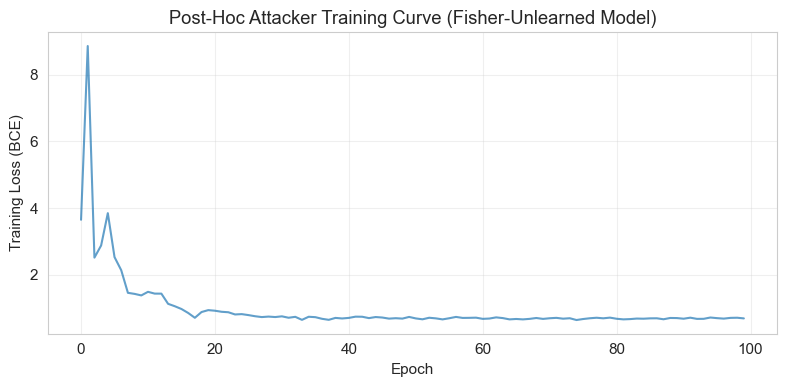

In [6]:
# Plot training curve
plt.figure(figsize=(8, 4))
plt.plot(train_losses, alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (BCE)')
plt.title('Post-Hoc Attacker Training Curve (Fisher-Unlearned Model)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Evaluate Attacker: Compute AUC and Low-FPR Metrics

In [7]:
# Get predictions
attacker.eval()
with torch.no_grad():
    forget_preds = torch.sigmoid(attacker(torch.FloatTensor(forget_feats).to(device))).cpu().numpy()
    unseen_preds = torch.sigmoid(attacker(torch.FloatTensor(unseen_feats).to(device))).cpu().numpy()
    retain_preds = torch.sigmoid(attacker(torch.FloatTensor(retain_feats).to(device))).cpu().numpy()

print("Prediction statistics:")
print(f"  Forget: {forget_preds.mean():.4f} ± {forget_preds.std():.4f}")
print(f"  Unseen: {unseen_preds.mean():.4f} ± {unseen_preds.std():.4f}")
print(f"  Retain: {retain_preds.mean():.4f} ± {retain_preds.std():.4f}")

Prediction statistics:
  Forget: 0.4695 ± 0.0139
  Unseen: 0.4388 ± 0.0269
  Retain: 0.4385 ± 0.0271


In [8]:
# F vs Unseen (matched negatives)
y_f_vs_u = np.concatenate([np.ones(len(forget_preds)), np.zeros(len(unseen_preds))])
scores_f_vs_u = np.concatenate([forget_preds.flatten(), unseen_preds.flatten()])
auc_f_vs_u = roc_auc_score(y_f_vs_u, scores_f_vs_u)

# F vs Retain
y_f_vs_r = np.concatenate([np.ones(len(forget_preds)), np.zeros(len(retain_preds))])
scores_f_vs_r = np.concatenate([forget_preds.flatten(), retain_preds.flatten()])
auc_f_vs_r = roc_auc_score(y_f_vs_r, scores_f_vs_r)

print(f"\nAUC (without CI):")
print(f"  F vs Unseen: {auc_f_vs_u:.4f}")
print(f"  F vs Retain: {auc_f_vs_r:.4f}")


AUC (without CI):
  F vs Unseen: 0.8675
  F vs Retain: 0.8689


In [9]:
# Bootstrap confidence intervals
def bootstrap_auc_ci(y_true, y_score, n_bootstrap=1000, confidence=0.95):
    """Compute bootstrap confidence interval for AUC."""
    n = len(y_true)
    aucs = []
    np.random.seed(42)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        try:
            auc = roc_auc_score(y_true[idx], y_score[idx])
            aucs.append(auc)
        except:
            pass
    aucs = np.array(aucs)
    alpha = 1 - confidence
    lower = np.percentile(aucs, 100 * alpha / 2)
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return lower, upper

print("Computing 95% confidence intervals (1000 bootstrap samples)...")
ci_f_vs_u = bootstrap_auc_ci(y_f_vs_u, scores_f_vs_u)
ci_f_vs_r = bootstrap_auc_ci(y_f_vs_r, scores_f_vs_r)

print(f"  F vs Unseen: [{ci_f_vs_u[0]:.4f}, {ci_f_vs_u[1]:.4f}]")
print(f"  F vs Retain: [{ci_f_vs_r[0]:.4f}, {ci_f_vs_r[1]:.4f}]")

Computing 95% confidence intervals (1000 bootstrap samples)...


  F vs Unseen: [0.8018, 0.9228]
  F vs Retain: [0.8041, 0.9246]


In [10]:
# TPR at low FPR
def compute_tpr_at_fpr(y_true, y_score, fpr_thresholds=[0.01, 0.001]):
    """Compute TPR at specific FPR thresholds."""
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    results = {}
    for target_fpr in fpr_thresholds:
        # Find threshold where FPR is closest to target
        idx = np.argmin(np.abs(fpr - target_fpr))
        results[f'tpr@{target_fpr:.1%}fpr'] = tpr[idx]
        results[f'fpr_actual@{target_fpr:.1%}fpr'] = fpr[idx]
    return results, fpr, tpr

tpr_f_vs_u, fpr_f_vs_u, tpr_curve_f_vs_u = compute_tpr_at_fpr(y_f_vs_u, scores_f_vs_u)
tpr_f_vs_r, fpr_f_vs_r, tpr_curve_f_vs_r = compute_tpr_at_fpr(y_f_vs_r, scores_f_vs_r)

print("\nTPR at Low FPR (F vs Unseen):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_u['tpr@1.0%fpr']:.4f} (actual FPR: {tpr_f_vs_u['fpr_actual@1.0%fpr']:.4f})")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_u['tpr@0.1%fpr']:.4f} (actual FPR: {tpr_f_vs_u['fpr_actual@0.1%fpr']:.4f})")

print("\nTPR at Low FPR (F vs Retain):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_r['tpr@1.0%fpr']:.4f} (actual FPR: {tpr_f_vs_r['fpr_actual@1.0%fpr']:.4f})")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_r['tpr@0.1%fpr']:.4f} (actual FPR: {tpr_f_vs_r['fpr_actual@0.1%fpr']:.4f})")


TPR at Low FPR (F vs Unseen):
  TPR @ 1.0% FPR: 0.0333 (actual FPR: 0.0099)
  TPR @ 0.1% FPR: 0.0000 (actual FPR: 0.0014)

TPR at Low FPR (F vs Retain):
  TPR @ 1.0% FPR: 0.0667 (actual FPR: 0.0106)
  TPR @ 0.1% FPR: 0.0000 (actual FPR: 0.0011)


## 6. Visualize ROC Curves

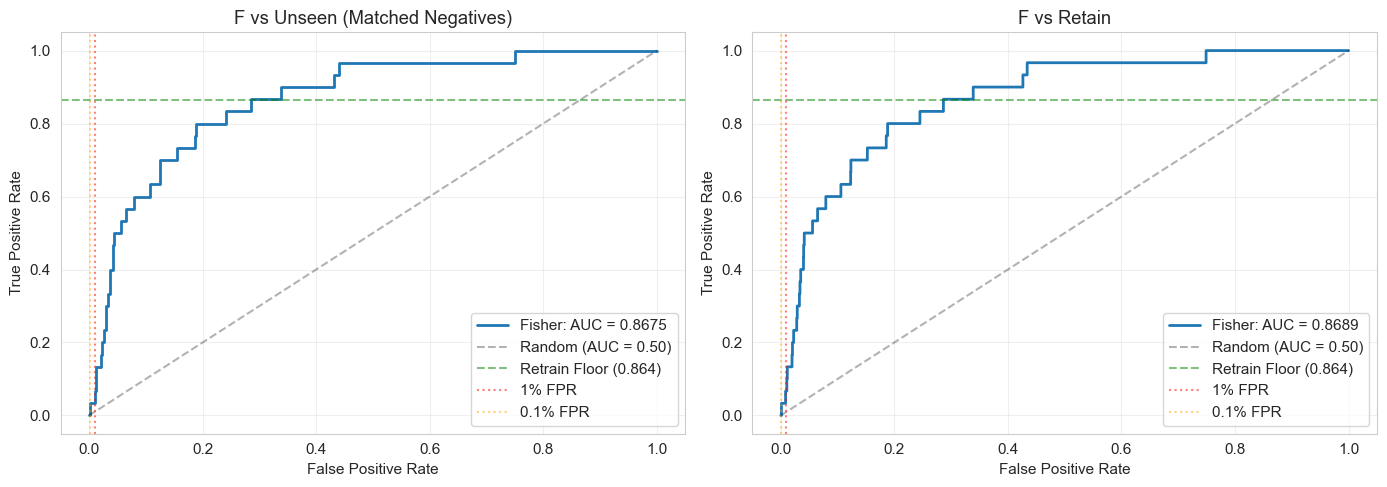

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F vs Unseen
axes[0].plot(fpr_f_vs_u, tpr_curve_f_vs_u, linewidth=2, label=f'Fisher: AUC = {auc_f_vs_u:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (AUC = 0.50)')
axes[0].axhline(0.864, color='green', linestyle='--', alpha=0.5, label='Retrain Floor (0.864)')
axes[0].axvline(0.01, color='red', linestyle=':', alpha=0.5, label='1% FPR')
axes[0].axvline(0.001, color='orange', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('F vs Unseen (Matched Negatives)')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# F vs Retain
axes[1].plot(fpr_f_vs_r, tpr_curve_f_vs_r, linewidth=2, label=f'Fisher: AUC = {auc_f_vs_r:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (AUC = 0.50)')
axes[1].axhline(0.864, color='green', linestyle='--', alpha=0.5, label='Retrain Floor (0.864)')
axes[1].axvline(0.01, color='red', linestyle=':', alpha=0.5, label='1% FPR')
axes[1].axvline(0.001, color='orange', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('F vs Retain')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/fisher_unlearn_roc.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Compare to Retrain Floor

In [ ]:
# Load retrain floor results
with open('outputs/p2/retrain_floor.json', 'r') as f:
    floor_results = json.load(f)

floor_auc = floor_results['avg_auc_floor']
floor_target_band = floor_results['target_band']

# Compute Fisher average AUC
avg_auc_fisher = (auc_f_vs_u + auc_f_vs_r) / 2

# Compute gap to floor
gap_to_floor = avg_auc_fisher - floor_auc

print("="*70)
print("FISHER UNLEARNING EVALUATION")
print("="*70)
print("\nAUC (Two-Negative, Conditioned):")
print(f"  F vs Unseen: {auc_f_vs_u:.4f} (95% CI: [{ci_f_vs_u[0]:.4f}, {ci_f_vs_u[1]:.4f}])")
print(f"  F vs Retain: {auc_f_vs_r:.4f} (95% CI: [{ci_f_vs_r[0]:.4f}, {ci_f_vs_r[1]:.4f}])")
print(f"  Average:     {avg_auc_fisher:.4f}")

print("\nTPR at Low FPR (F vs Unseen):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_u['tpr@1.0%fpr']:.4f}")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_u['tpr@0.1%fpr']:.4f}")

print("\nTPR at Low FPR (F vs Retain):")
print(f"  TPR @ 1.0% FPR: {tpr_f_vs_r['tpr@1.0%fpr']:.4f}")
print(f"  TPR @ 0.1% FPR: {tpr_f_vs_r['tpr@0.1%fpr']:.4f}")

print("\n" + "="*70)
print("COMPARISON TO RETRAIN FLOOR")
print("="*70)
print(f"\nRetrain floor:     AUC = {floor_auc:.4f}")
print(f"Fisher unlearning: AUC = {avg_auc_fisher:.4f}")
print(f"Gap to floor:      ΔAUC = {gap_to_floor:+.4f}")
print(f"\nTarget band: [{floor_target_band[0]:.4f}, {floor_target_band[1]:.4f}]")

# Success criteria
within_target = floor_target_band[0] <= avg_auc_fisher <= floor_target_band[1]

print("\n" + "="*70)
print("SUCCESS CRITERIA")
print("="*70)

if within_target:
    print("\n✓ SUCCESS: Fisher unlearning WITHIN target band!")
    print(f"  {avg_auc_fisher:.4f} ∈ [{floor_target_band[0]:.4f}, {floor_target_band[1]:.4f}]")
    print("\n  Fisher-based unlearning achieved retrain-equivalence.")
    print("  Privacy improved without catastrophic utility loss.")
else:
    if gap_to_floor > 0:
        print("\n✗ ABOVE target band - privacy still leaking")
        print(f"  Gap: +{gap_to_floor:.4f} AUC points above floor")
        print("\n  Fisher scrubbing may need:")
        print("  - More scrub steps")
        print("  - Higher scrub learning rate")
        print("  - Lower Fisher damping")
    else:
        print("\n? BELOW target band - unexpected (better than retrain)")
        print(f"  Gap: {gap_to_floor:.4f} AUC points below floor")
        print("\n  This is unusual and may indicate:")
        print("  - Attacker training instability")
        print("  - Random variation (check CI)")

print("\n" + "="*70)

## 8. Save Results

In [ ]:
import os
os.makedirs('outputs/p2', exist_ok=True)

results = {
    'timestamp': str(np.datetime64('now')),
    'method_id': 'fisher_unlearning',
    'method': 'fisher_scrub_finetune',
    'model': 'fisher_unlearn_structured',
    'forget_size': int(len(forget_idx)),
    'unseen_size': int(len(unseen_idx)),
    'retain_size': int(len(retain_idx)),
    'auc_f_vs_unseen': float(auc_f_vs_u),
    'auc_f_vs_retain': float(auc_f_vs_r),
    'auc_f_vs_unseen_ci': [float(ci_f_vs_u[0]), float(ci_f_vs_u[1])],
    'auc_f_vs_retain_ci': [float(ci_f_vs_r[0]), float(ci_f_vs_r[1])],
    'tpr_at_fpr_f_vs_unseen': {k: float(v) for k, v in tpr_f_vs_u.items()},
    'tpr_at_fpr_f_vs_retain': {k: float(v) for k, v in tpr_f_vs_r.items()},
    'avg_auc': float(avg_auc_fisher),
    'retrain_floor': float(floor_auc),
    'target_band': floor_target_band,
    'gap_to_floor': float(gap_to_floor),
    'within_target': within_target,
    'training_metadata': metadata
}

with open('outputs/p2/fisher_unlearn_eval.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to: outputs/p2/fisher_unlearn_eval.json")
print("Figures saved to: outputs/p2/fisher_unlearn_roc.png")

## 9. Training History Visualization

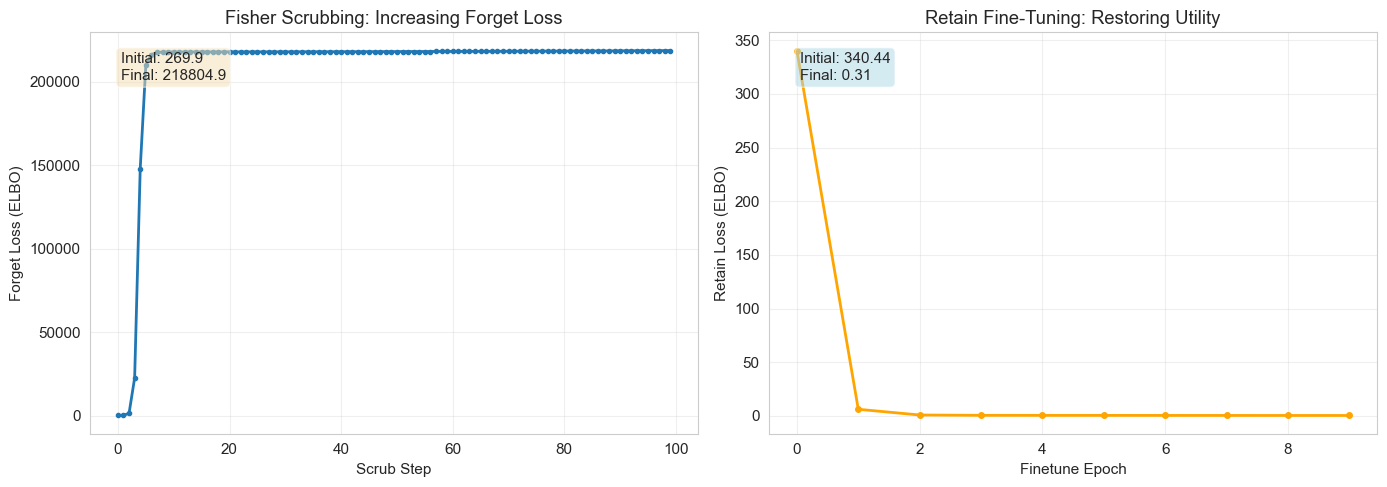


Training Summary:
  Scrub phase: 269.9 → 218804.9 (increase by 810.6x)
  Finetune phase: 340.44 → 0.31 (decrease by 1080.9x)


In [14]:
# Load training history
with open('outputs/p2/fisher_unlearn_structured/training_history.json', 'r') as f:
    history = json.load(f)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scrub losses (forget loss should increase)
scrub_losses = history['scrub_losses']
axes[0].plot(scrub_losses, linewidth=2, marker='o', markersize=3)
axes[0].set_xlabel('Scrub Step')
axes[0].set_ylabel('Forget Loss (ELBO)')
axes[0].set_title('Fisher Scrubbing: Increasing Forget Loss')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'Initial: {scrub_losses[0]:.1f}\nFinal: {scrub_losses[-1]:.1f}',
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Finetune losses (retain loss should decrease)
finetune_losses = history['finetune_losses']
axes[1].plot(finetune_losses, linewidth=2, marker='o', markersize=4, color='orange')
axes[1].set_xlabel('Finetune Epoch')
axes[1].set_ylabel('Retain Loss (ELBO)')
axes[1].set_title('Retain Fine-Tuning: Restoring Utility')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f'Initial: {finetune_losses[0]:.2f}\nFinal: {finetune_losses[-1]:.2f}',
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig('outputs/p2/fisher_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining Summary:")
print(f"  Scrub phase: {scrub_losses[0]:.1f} → {scrub_losses[-1]:.1f} (increase by {scrub_losses[-1]/scrub_losses[0]:.1f}x)")
print(f"  Finetune phase: {finetune_losses[0]:.2f} → {finetune_losses[-1]:.2f} (decrease by {finetune_losses[0]/finetune_losses[-1]:.1f}x)")